In [1]:
from helpers import *
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading in data and cleaning up unnecessary columns.
truth_seeker = pd.read_csv("TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv")
truth_seeker = truth_seeker.drop(columns=["Unnamed: 0"])

## Testing Features
In machine learning, features represent one measureable aspect of an item. For an example, if there were a model which output a suggested musical genre for a person based on age and gender, age and gender would be considered the features. Selecting features for a model can be a complex process. Oftentimes it's assumed the more information you give an algorithm the better but that's not necessarily true meaning it's important to be intentional about which features are chosen. There are many different ways to choose features such as feature importance which looks at an individual feature's impact on a model and decides from there. I chose to do a more universal approach towards feature selection in an effort to verify the results discussed by Suhaib Kh. Hamed, Mohd Juzaiddin Ab Aziz, and Mohd Ridzwan Yaakub in their paper "A Review of Fake News Detection Models: Highlighting the Factors Affecting Model Performance and the Prominent Techniques Used". 

In this paper, they identify two primary categories of features in relation with fake news. There are content-based and user-based features. Content-based features are metrics derived from the body of text such as number of words or verb tenses. In contrast, user-based features are derived from the user who posted the text so when looking at tweets, that would be things like follower count or mentions. Beyond this I wanted to test a few other categories of metrics. The Truth Seeker dataset includes authenticity metrics for the user by evaluating the the likelihood of a user being a bot and giving a corresponding score as well as an overall credibility score. I was interested to see how this metric would affect a model looking at fake news. Initially I thought it would a 1-to-1 relationship where if something was determined to be a bot that meant the text would be false but later realised that there are also bots that tweet out things that are pulled from new articles and would therefore be considered true. I also decided to test what would happened if the content-based features were split into further categories. I divided them into a lexical category, which handled anything that had to do with the actual words so things like tenses and parts of speech, and a spaCy category, which includes any features that have to do with the spaCy tags present in a tweet. spaCy is a natural language processing library for Python which includes part-of-speech tagging. The dataset included a number of stats related to the percentage of certain tags in a tweet. 

This resulted in 5 unique features sets and an additional set which includes all the features:
- Content
- User
- Authenticity
- Lexical
- spaCy
- All features

To keep some of the variability controlled, I used the same output for all of them which was a binary number for the target rather than true/false but that would also work. I also decided to use the Random Forest Classifier because amongst the models I tested it consistently had one of the highest accuracies. The other model I considered was a Support Vector Classifier but that required a significantly larger amount of computing power and time for no noticeable difference in accuracy.

In [3]:
# Extracting all features which are derived based on the content.
truth_seeker_content = truth_seeker[["unique_count", "present_verbs", "total_count", "past_verbs", "ORG_percentage", "adjectives", 
                                     "NORP_percentage", "pronouns", "GPE_percentage", "TOs", "PERSON_percentage", "determiners", 
                                     "MONEY_percentage", "conjunctions", "DATE_percentage", "dots", "CARDINAL_percentage", "exclamation", 
                                     "PERCENT_percentage", "questions", "ORDINAL_percentage", "ampersand", "FAC_percentage", "capitals", 
                                     "LAW_percentage", "quotes", "PRODUCT_percentage", "digits", "EVENT_percentage", "long_word_freq", 
                                     "TIME_percentage", "short_word_freq", "LOC_percentage", "ORG_percentage", "WORK_OF_ART_percentage", 
                                     "QUANTITY_percentage", "LANGUAGE_percentage", "Max word length", "Min word length", "Average word length"]]

# Extracting all features which are derived based on the user.
truth_seeker_user = truth_seeker[['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'listed_count', 
                                  'following', 'mentions', 'quotes','replies', 'retweets', 'favourites', 'hashtags', 'URLs']]

# Extracting all features which are used as metrics of credibility.
truth_seeker_auth = truth_seeker[['BotScore', 'BotScoreBinary', 'cred', 'normalize_influence']]

# Extracting all features which are derived based on lexical structure in the tweet.
truth_seeker_lexical = truth_seeker[['present_verbs', 'past_verbs', 'adjectives', 'adverbs', 'adpositions', 'pronouns', 'TOs', 
                                     'determiners', 'conjunctions', 'dots', 'exclamation', 'questions', 'ampersand', 'capitals', 
                                     'digits', 'long_word_freq', 'short_word_freq']]

# Extracting all features which are derived based on spaCy tags.
truth_seeker_spaCy = truth_seeker[["ORG_percentage", "NORP_percentage", "GPE_percentage", "PERSON_percentage", "MONEY_percentage", "DATE_percentage", 
                                   "CARDINAL_percentage", "PERCENT_percentage", "ORDINAL_percentage", "FAC_percentage", "LAW_percentage", 
                                   "PRODUCT_percentage", "EVENT_percentage", "TIME_percentage", "LOC_percentage", "ORG_percentage", 
                                   "WORK_OF_ART_percentage", "QUANTITY_percentage", "LANGUAGE_percentage"]]

# Extracting all features.
truth_seeker_features = truth_seeker.drop(columns=["majority_target", "statement", "BinaryNumTarget", "tweet", "embeddings"])

# Extracting label column for data.
truth_seeker_output = truth_seeker["BinaryNumTarget"]

# Creating sklearn model instance.
rf_model = RandomForestClassifier()


In [4]:
# Create a list to store evaluation metrics for each set of features
evaluation_results_data = []

# Iterate over feature sets and store evaluation metrics
feature_sets = [truth_seeker_features, truth_seeker_spaCy, truth_seeker_lexical, truth_seeker_auth, truth_seeker_user, truth_seeker_content]
for features, feature_set_name in zip(feature_sets, ["All Features", "spaCy", "Lexical", "Auth", "User", "Content"]):
    metrics_data = train_and_evaluate_data(features, truth_seeker_output, rf_model)
    evaluation_results_data.append({"feature_set_name": feature_set_name, "metrics_data": metrics_data})

# Create a DataFrame for better plotting
df_results = pd.DataFrame(evaluation_results_data)

# Extract metric names for the y-axis
metric_names = list(df_results['metrics_data'][0].keys())

After extracting all the groupings I wanted to test, the loop above handles running the testing function on each of the sets and adding all of the metrics to a list to simplifying analysis. I chose to look at eight different metrics: accuracy, precision, recall, and F1 score. I chose to leave out the true/false postives/negatives because precision, recall, and the F1 score are all derived values from those numbers and there wasn't much to gain from looking at just the raw numbers. 

In the paper mentioned above, they said that using content-based features yielded a higher accuracy than user-based features which is reflected in my results as well. When looking at exclusively content vs exclusively user, content is higher but using all features still results in a slightly higher accuracy. An interesting thing to note is that despite losing all of the user-based features the accuracy only decreases by ~0.01. This is a fairly negligible value and is a good example of where someone might choose a slightly lower accuracy to save on computational power. While the paper only spoke about accuracy in reference to content-based vs user-based features, I was able to draw another more general conclusion. Despite content-based features having a realtively higher accuracy, when those same features are broken down into seperate categories, the accuracy drops by almost 0.1. This leads to conclusion that the accuracy comes from the combination of lexical and spaCy features and that neither seem to be more influential in the combined accuracy.

When analysing the rest of the metrics calculated, I chose to draw conclusions about each set instead of comparing just the values of one metric for each of them. 

All Features:

This dataset has the highest overall accuracy, precision, recall, and F1 score. It seems to be the most comprehensive among the feature sets, capturing a good balance between precision and recall.

spaCy:

This dataset has the lowest accuracy and F1 score amongst the sets. However precision is relatively high, recall is lower, suggesting that the model using spaCy features may not be as effective at capturing all relevant cases.

Lexical:

The lexical dataset shows moderate performance across all metrics, with accuracy, precision, recall, and F1 score. It strikes a balance between precision and recall, and its overall performance is better than spaCy.

Auth:

The Auth dataset performs similarly to the lexical set, with accuracy, precision, recall, and F1 score. It indicates that the features related to authenticity contribute moderately to the model's predictive ability.

User:

This dataset shows relatively good precision but lower recall, resulting in a moderate F1 score and  accuracy. It suggests that the user-related features may be more precise in identifying positive cases but may miss some relevant instances.

Content:

The content dataset has high accuracy, precision, recall, and F1 score. It performs well across all metrics, indicating that content-related features contribute significantly to the model's effectiveness.

In summary, the "All Features" dataset performs the best overall, while the "spaCy" dataset has the lowest performance. Between user-based and content-based features, content-based features perform better which validates the results of the paper. The other datasets fall in between, with variations in precision, recall, and overall accuracy.

Below is code for seeing all the metrics in table form as well as plots to compare them.

In [5]:
# Print metrics as a table
print("{:<30}".format("Feature Set"), end="")
for metric_name in metric_names:
    print("{:<15}".format(metric_name), end="")
print()  # Newline

for row in df_results.itertuples(index=False):
    feature_set_name = row.feature_set_name
    metrics_values = [row.metrics_data[metric_name] for metric_name in metric_names]

    print("{:<30}".format(feature_set_name), end="")
    for value in metrics_values:
        print("{:<15.4f}".format(value), end="")
    print()  # Newline

Feature Set                   Accuracy       Precision      Recall         F1 Score       
All Features                  0.6932         0.7087         0.6808         0.6945         
spaCy                         0.6047         0.6235         0.5758         0.5987         
Lexical                       0.6313         0.6382         0.6465         0.6424         
Auth                          0.6192         0.6280         0.6291         0.6285         
User                          0.6431         0.6619         0.6196         0.6401         
Content                       0.6828         0.6900         0.6910         0.6905         


In [ ]:
# Iterate over metric names and create separate plots for each metric
for metric_name in metric_names:
    # Create a new plot for each metric
    fig, ax = plt.subplots(figsize=(12, 8))

    # Convert metric values to strings to handle potential float values
    metric_values = df_results['metrics_data'].apply(lambda x: x[metric_name])

    # Bar plot for each metric
    ax.bar(
        x=np.arange(len(df_results)),
        height=metric_values.astype(float),
        width=0.8,
    )

    # Set labels and title for each plot
    ax.set_xticks(np.arange(len(df_results)))
    ax.set_xticklabels(df_results['feature_set_name'])
    ax.set_xlabel('Feature Sets')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} for Different Feature Sets')

    # Show the plot
    plt.show()

Another aspect of feature testing, I wanted to explore was feature importance. Feature importance in a machine learning model refers to the relative importance of each feature in making predictions. It's important to note that a high feature importance doesn't necessarily mean that including that feature will always improve your model.

For a Random Forest Classifier, feature importance is calculated based on how much a feature contributes to reducing impurity in decision trees during the training process. The primary advantage of selecting top features would be to reduce overfitting by excluding irrelevant features which with a dataset with so many features could be something to look into.

In [7]:
# Split the data into training and testing sets (e.g., 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    truth_seeker_features,
    truth_seeker_output,
    test_size=0.25,  # Adjust the test_size as needed
    random_state=100  # You can set a random seed for reproducibility
)

In [8]:
# Create a RandomForestClassifier instance
rf_model = RandomForestClassifier()

# Train the model
rf_model.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Get feature names
feature_names = list(X_train.columns)

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

feature_importances

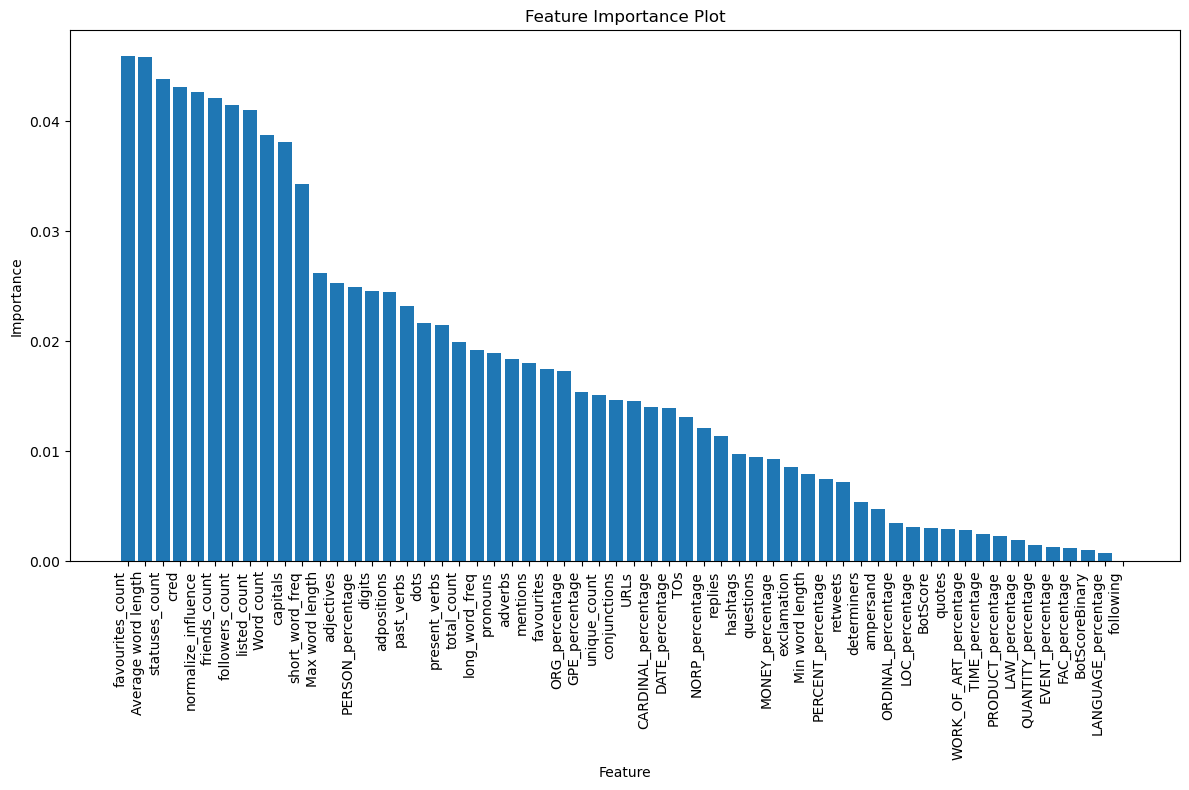

In [9]:
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90, ha='right')  # Adjust rotation and horizontal alignment
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance Plot")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

You can see here that the top features are favorites_count, Average word length, statuses_count, and cred. While this could mean that these features are more indicative of whether or not a tweet is true, the only certain conclusion we can draw is that these were the most influential features when looking at all features. If we were to remove even one of the features, that could change the order of importance so this doesn't mean that in every scenario these features will have the highest importance value.